In [1]:
using PyPlot

INFO: Loading help data...


# Basic Finite Element Implementations in Julia

by [Christoph Ortner](http://homepages.warwick.ac.uk/staff/C.Ortner/)  
last update 11 May 2016
tested ok on Julia 0.4.5

In this notebook we implement a basic variant of the finite element method. A production-quality FE code would look very different. These are codes designed for quick testing, without much concern for performance. They are useful as an introduction to Julia, or if you are a numerical analyst who wants to write quick and readable finite element codes, with full control over all aspects of the assembly, for rapid testing of theorems.

A basic understanding of theory and implementation of the finite element method is required to understand this notebook. Over time, I plan to integrate the required knowledge into the notebook, but for now this is oriented as a Julia tutorial rather than general FEM knowledge.

**Content:**  

1. For just a quick look, read only section 1. This is all that is required to then go and write your own FE codes. 
2. In section 2 I show how a simple operator overloading trick can be used to make the code look a little nicer, i.e., more readable. 
3. In section 3 I then show how the code can be very quickly generalised to a more general elliptic PDE. 
4. Finally, in section 4 I do a basic convergence analysis. (which is also a great way for checking that the code is correct)

## 1. Quick First Implementation

To get started, we solve the Laplace equation
$$\begin{align*}
 - \Delta u &= 1, \quad  x \in \Omega \\
  u &= 0, \quad x \in \partial \Omega_\mathrm{D}, \\
  \nabla u \cdot n &= 0, \quad x \in \partial\Omega_\mathrm{N}.
\end{align*}$$
using the P1 finite element method.

Typical FEM implementations in Matlab are vectorised and do *not* loop over elements, but instead over quadrature points. We will not follow this here, but instead write a FEM assembly closer to a C or C++ implementation. This is easier to write and read, more easily extendable to other finite element flavours, and for large meshes more memory efficient.

### 1.1 Meshing & Plotting

We will just build a canonical triangulation by hand. Normally we would probably import it from an external mesh generator. For a quick 2D Delaunay triangulation, one could probably use the [mplot3d functionality](http://matplotlib.org/api/tri_api.html#matplotlib.tri.Triangulation), but I have not tested this. I could not get the [VoronoiDelaunay](https://github.com/skariel/VoronoiDelaunay.jl) to work for this demonstration.

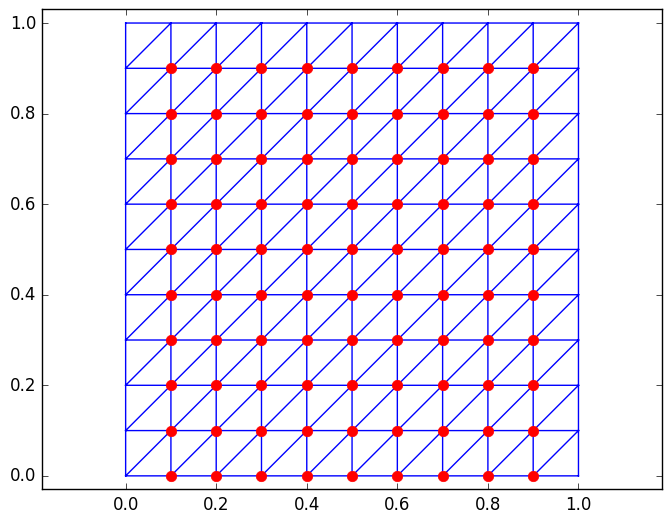

In [2]:
# `square` implements a finite element mesh with
# mixed Dirichlet and Neumann boundary condition
# the output are
#     X : 2 x (N+1)^2 array of points
#     T : 3 x (2*N^2) array of elements (connectivity array)
#     Ifree : list of free finite element nodes
#
function square(N)
    # generate the nodes
    X = linspace(0, 1, N+1) * ones(1, N+1)
    X = [X[:]'; X'[:]']
    # allocate the elements
    T = zeros(Int, 3, 2*N^2)
    # loop through "squares" and create two triangles per square
    idx = 0
    for icol = 1:N, irow = 1:N
        a = (icol-1)*(N+1)+irow
        idx += 1
        T[:,idx] = [a; a+1; a+N+2]
        idx += 1
        T[:,idx] = [a; a+N+2; a+N+1]
    end
    # determine the free nodes
    Ifree = find( (X[1,:] .> 0) & (X[1,:] .< 1) & (X[2,:] .< 1) )
    # return the mesh information
    return X, T, Ifree
end

# create a mesh
X, T, Ifree = square(10)

# basic mesh plot
triplot(slice(X,1,:), slice(X,2,:), triangles=T'-1)
plot(X[1,Ifree], X[2,Ifree], "r.", markersize=15)
axis("equal"); axis([-.03, 1.03, -.03, 1.03]);

We can see that plotting through PyPlot is not (yet) without pain. We have to make sure that the position arrays are 1D, and that the indexing is taken care of. (The -1.) It will therefore be useful to have a little wrapper routine that takes care of some of those things for a quick surface plot.

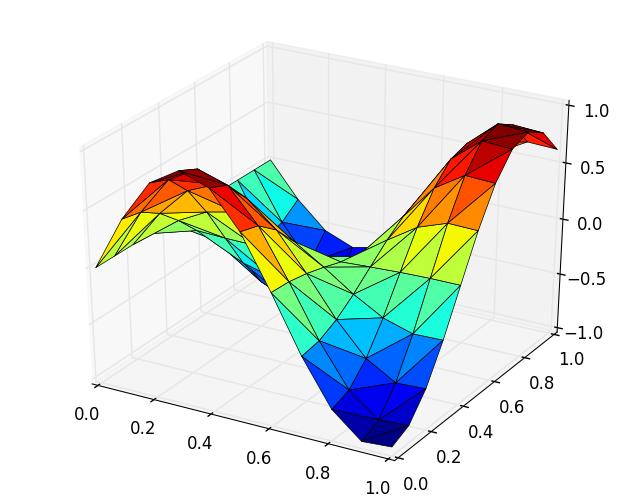

In [3]:
trisurf(T, X, Z, colormap="jet") = 
    PyPlot.plot_trisurf(slice(X,1,:), slice(X,2,:), Z[:], triangles=T'-1, 
                        cmap=ColorMap(colormap), linewidth=0.5)

# testing this:
Z = sin(5*X[1,:]) .* cos(4*X[2,:])
trisurf(T, X, Z);

### 1.2 Assembling the Stiffness Matrix

As usual, assembling a sparse matrix in CCS is very slow, so we will do it in triplet format, and then convert to CCS.

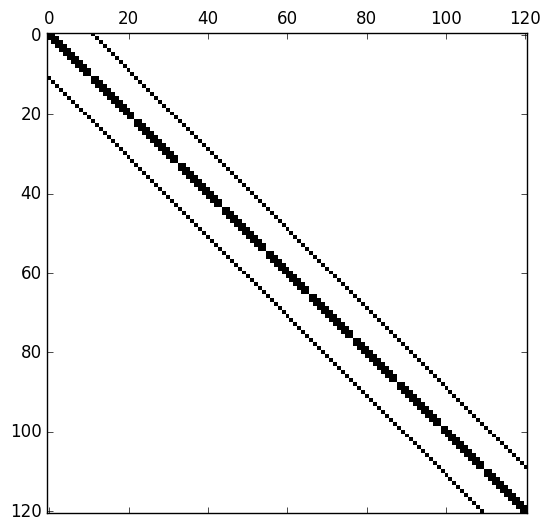

In [4]:
function simple_stiffmat(X, T)
    # collect some info
    nT = size(T, 2); nP = size(X, 2); dim = size(X, 1)
    facdim = factorial(dim)
    # allocate + helper arrays
    D = [-ones(1, dim), eye(dim)]     # reference grad operator
    F = zeros(nP)                     # rhs
    It = Int[]   # triplet format for matrix
    Jt = Int[]
    Vt = Float64[]

    # loop through elements
    idx = 0
    for k = 1:nT
        # Jacobian
        J = X[:, T[:, k]] * D
        # transformed local stiffness matrix
        B = D / J
        A = det(J)/facdim * B * B'
        # write into triplet format; note how we use push! to grow the 
        # arrays dynamically. this is fairly efficient, so it is not
        # necessary to know the dimensions beforehand
        for i = 1:(dim+1), j = 1:(dim+1)
            push!(It, T[i,k])
            push!(Jt, T[j,k])
            push!(Vt, A[i,j])
        end
        # assemble right-hand side (f(x) = 1)
        F[T[:,k]] += det(J)/facdim/(dim+1)  
    end
    return sparse(It, Jt, Vt, nP, nP), F
end

# assemble a matrix and plot the sparsity pattern to check that it looks ok
X, T = square(10)
A, F = simple_stiffmat(X, T)
spy(A);

We are now ready to solve the FE problem. Note that sparse linear algebra implemente in core Julia, so we don't have to worry about this.

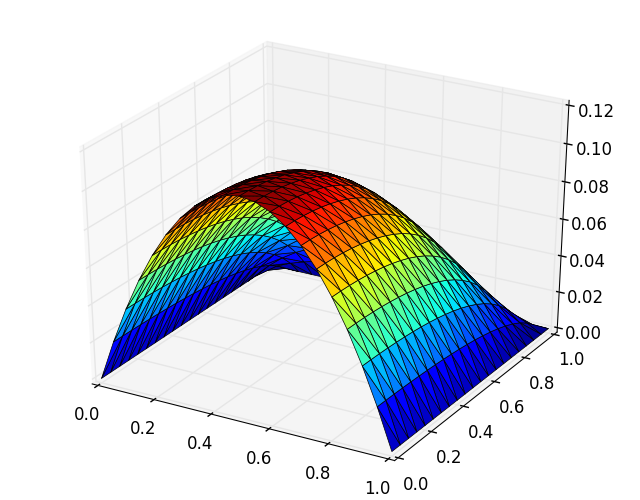

In [5]:
# construct a finite element grid
X, T, Ifree = square(20)
# assemble the stiffness matrix and rhs (for - \Delta u = 1)
A, F = simple_stiffmat(X, T)

# solve the linear system and plot the solution
U = zeros(size(X,2))
U[Ifree] = A[Ifree,Ifree] \ F[Ifree]
trisurf(T, X, U); 

## A "Julian" Implementation

The code above is very much a Matlab-style code. It does not use any of the conveniences of the Julia language. It was the code I wrote immediately after I switch from Matlab to Julia. Now I would write something more along the following lines. This is not something I would do
for a "quick hack", but if I want code that should survive for longer and possibly grow
over time.

A key aspect of this style of writing is to write many small functions rather than long
chunks that are difficult to debug. I find that it takes longer to get something up and
running but once it does run, it usually has fewer (if any) bugs. Julia's agressive
inlining ensures that there is no performance penalty at all.

In [9]:
# ================== ITERATORS ===========================================
# a mesh is defined as a pair (X, T), but it could also be an abstract object.
# to shield ourselves from the implementation of the mesh, we can define an iterator
# To see how iterators work, look at the documentation and at the following blog-post:
#    http://slendermeans.org/julia-iterators.html
type ElementIterator
    X
    T
end
elements(X, T) = ElementIterator(X, T)
Base.start(elit::ElementIterator) = 0
Base.done(elit::ElementIterator, idx::Int) = (idx == size(elit.T, 2))
Base.next(elit::ElementIterator, idx::Int) = P1_element(elit.X, elit.T[:, idx+1]), idx+1

# next we define a function that will return the element information
# in this case, we need the element volume and the gradient operator
# but we could provide anything else we want here as well, maybe
# nicely encapsulated in a type
P1_element(X, t) = tuple(t, vol_and_grad( X[:, t[2:3]] .- X[:, t[1]] )...)
vol_and_grad(J) = det(J) / 2, [ -1.0 -1.0; 1.0 0.0; 0.0 1.0 ] / J

# ================== OPERATOR OVERLOADING =====================================
# next, we can have some fun and play with operator overloading to 
# provide a "prettier" assembly of the global matrix
# This is something that I normally don't do in practise, but 
# it is still a nice way to learn more about abstractions

# we begin by defining a matrix triplet type
type SparseTriplet
    I
    J
    V
end

# and a default constructor
SparseTriplet() = SparseTriplet( zeros(Int, 0), zeros(Int, 0), zeros(Float64, 0) )

# The neat thing about operator overloading is that we can write into 
# SparseTriplet as if it were a matrix; see in the next cell how this works
function setindex!(A::SparseTriplet, v, iRow, iCol)
    for i=1:length(iRow), j = 1:length(iCol)
        push!(A.I, iRow[i])
        push!(A.J, iCol[j])
        push!(A.V, v[i,j])
    end
end

# to make += work, we do the following, but this is just syntactic suger
# and has no real meaning!
getindex(A::SparseTriplet, iRow, iCol) = zeros(length(iRow), length(iCol))

# Finally, we need a conversion to sparse matrix format
# (note that sparse is in Base, so we need to overload it)
Base.sparse(A::SparseTriplet) = sparse(A.I, A.J, A.V);

# ==========================================================================
# After all of this boiler-plate work, this is how assembly looks like
# much more pleasant, and we can now focus on the actual model
function simple_stiffmat2(X, T)
    # initialise some arrays
    F = zeros(size(X,2))  # rhs
    A = SparseTriplet()   # sparse matrix assembly
    
    # loop through elements
    for (t, vol, GRAD) in elements(X, T)
        # assemble matrix
        A[t, t] += vol * GRAD * GRAD'
        # assemble right-hand side (f(x) = 1)
        F[t] += vol/3
    end
    return sparse(A), F
end
;

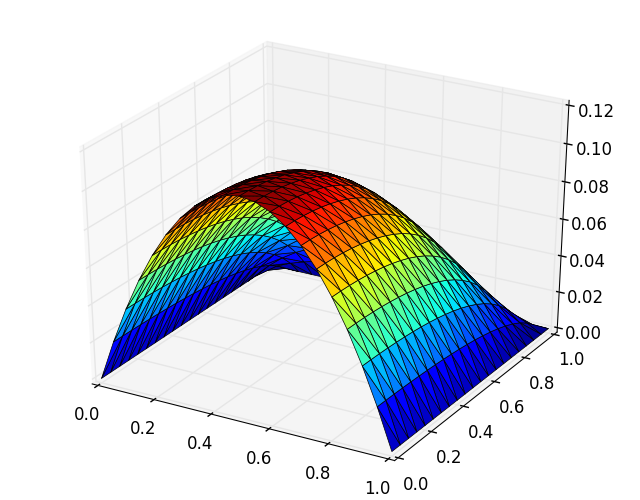

In [10]:
# assemble the system
X, T, Ifree = square(20)
A, F = simple_stiffmat2(X, T)

# solve system, plot solution
U = zeros(size(X,2))
U[Ifree] = A[Ifree,Ifree] \ F[Ifree]
trisurf(T, X, U); 

### **WARNING: ** the rest of this notebook has not been fixed for Julia 0.4 yet!

## 3. A General P1 Elliptic PDE Solver

We now implement a P1 solver for a more general elliptic PDE of the form
\begin{align*}
    - \mathrm{div} A \nabla u + b \cdot \nabla u + c u &= f_\mathrm{b}, \quad x \in \Omega\\
    u &= u_\mathrm{D}, \quad x \in \partial\Omega_\mathrm{D}, \\
    \nabla u \cdot n &= f_\mathrm{s}, \quad x \in \partial\Omega_\mathrm{N}
\end{align*}
building on the code developed above, where $A : \Omega \to \mathbb{R}^{d \times d}, b : \Omega \to \mathbb{R}^d, c : \Omega \to \mathbb{R}, f_\mathrm{b} : \Omega \to \mathbb{R}, u_\mathrm{D} : \Omega \to \mathbb{R}$, and $f_\mathrm{s} : \partial\Omega_N \to \mathbb{R}$. (The extended domains of definition of these functions is intended as this makes for an easier implementation.)

The main extension to the Laplacian code are (i) that we also need an assembly over the Neumann boundary and (ii) that we now admit keyword parameters that specify the coefficient functions. The Dirichlet boundary condition will be imposed below in the script where we are solving the problem. To treat the non-constant coefficient functions we use midpoint approximations.

In the next section we will then test this implementation by checking the rate of convergence.

In [14]:
# for assembling the boundary integrals, we will need a list of boundary edges. 
# This is constructed in the following function
function boundary_faces(T)
    # All edges with the interior edges duplicated
    E = [T[[1, 2], :] T[[1,3],:] T[[2,3],:]];
    # sort columns, then sort them lexicographically
    E = sort(E, 1); E = sortcols(E)
    # remember all indices of boundary edges
    isBdry = ones(size(E,2))
    for i = 1:size(E,2)-1
        if E[:,i]==E[:,i+1]
            isBdry[[i,i+1]] = 0
        end
    end
    return E[:, find(isBdry)]
    end; 

# # test this code
# X, T, Ifree = square(10)
# E = boundary_faces(T)
# @show E
# triplot(slice(X,1,:), slice(X,2,:), triangles=T'-1)
# for i = 1:size(E,2)
#     plot(squeeze(X[1,E[:,i]],1), squeeze(X[2,E[:,i]],1), "-b", linewidth=3)
# end
# plot(squeeze(X[1,Ifree],1), squeeze(X[2,Ifree],1), "r.", markersize=15)
# axis([-.03,1.03,-.03,1.03])

boundary_faces (generic function with 1 method)

In [15]:
# We write this code as a strict extension of simple_stiffmat, employing 
# default arguments for the functions.
#
function ellipticPDE(X, T; 
    Afun = x->eye(length(x)), 
    bfun = x->zeros(length(x)), 
    cfun = x->0,
    fbfun = x->1,
    fsfun = x->0)

    # collect some info
    nT = size(T, 2); nP = size(X, 2); dim = size(X, 1)
    facdim = factorial(dim)

    # allocate + helper arrays
    D = [-ones(1, dim), eye(dim)]    # reference grad operator
    M = (ones(dim+1,dim+1)+eye(dim+1)) / (factorial(dim+2))   # reference mass matrix
    F = zeros(nP)                    # rhs forces
    L = SparseTriplet((dim+1)^2*nT)  # triplet format for stiffness matrix
    
    # for surface assembly we also need the following array
    isFree = zeros(nP);

    # loop through elements
    for k = 1:nT
        # prepare quantities for assembly
        # corner indices
        iT = T[:, k]
        # Jacobian
        J = X[:, iT] * D
        # element midpoint (for quadrature)
        xmid = sum(X[:, iT], 2) / (dim+1)
        # transformed gradient operator
        DT = D / J
        
        # assembly of local matrix
        # assembly of `-div (A \nabla u)`  (~ replace A with P_0 A)
        a = det(J) / facdim * DT * Afun(xmid) * DT'
        # assembly of `b \cdot \nabla u`  (~replace b with P_0 b)
        a += det(J) * (M * ones(dim+1)) * (bfun(xmid)'*DT')
        # assembly of `c u`  (~ replace c with P_0 c)
        a += det(J) * cfun(xmid) * M

        # update global matrix write into triplet format
        L[iT, iT] += a
        
        # assemble the bulk contribution to the right-hand side 
        #    (~ replace fb with P_0 fb)
        F[iT] += det(J) * (M * ones(dim+1)) * fbfun(xmid) 
    end
        
    # Assembly of surface forces
    # the Surface contribution needs (n-1) - dimensional versions of D and M.
    Ds = D[1:dim, 1:(dim-1)]
    Ms = (dim+2) * M[1:dim, 1:dim] * ones(dim)
    # loop over boundary edges
    E = boundary_faces(T)    
    for k = 1:size(E,2)
        iE = E[:, k]
        Js = X[:, iE] * Ds
        xmid = sum(X[:,iE], 2) / dim
        # assembly of forces
        F[iE] += sqrt(det(norm(Js'*Js))) * (Ms * fsfun(xmid))
    end
   
    # return the matrix and right-hand side
    return sparse(L), F
end;


In [16]:
# quick sanity check: make sure this gives the same result as the simple assembly
X, T, Ifree = square(20)
A1, f1 = simple_stiffmat2(X, T)
u1 = A1[Ifree,Ifree] \ f1[Ifree]
A2, f2 = ellipticPDE(X, T)
u2 = A2[Ifree,Ifree] \ f2[Ifree]
norm(u1-u2, Inf)

4.163336342344337e-17


## 4. Convergence Rate for a Toy Problem

If we setup the problem in such a way that the solution $u$ belongs to the space $H^2(\Omega)$, then according to Finite element theory, we should obtain the convergence rates
$$
   \| \nabla (u_h - u) \|_{L^2} + h \| u_h - u \|_{L^2} \leq C h^2,
$$
where $h = \max \text{diam}(T)$ over all elements $T$. In the following, we specify some coefficient functions 
$$
A(x) = \left(\begin{matrix} 1+x_2 & 0 \\ 0 & 1+x_1 \end{matrix} \right), \qquad
b(x) = x, \qquad c(x) = \cos(x_1 x_2),
$$
and a prescribed exact solution
$$
u(x) = \exp\big( x_1 x_2 \big)
$$
to test that we do obtain these rates. This is also an excellent way to debug our code. The forcing functions $f_b, f_s$ are simply obtained by inserting the solution in the differential operator.

**Remark:** Since our mesh is uniform (not just quasi-uniform) we get a superconvergence effect, i.e., $\| \nabla u_h - \nabla I_h u \|_{L^2} \lesssim h^2$. In order to avoid this, we must perturb the finite element nodes. If we turn this perturbation off, then we can see the superconvergence.


In [17]:
# specify the problem: 
# some arbitrary coefficiant funcitons without meaning.
#-------------------------------------------------------
# the coefficients A, b, c are specified.
Afun(x) = [[1+x[2] 0], [0 1+x[1]]]
# Afun(x) = eye(length(x))
bfun(x) = x
cfun(x) = cos(x[1] * x[2])
# the prescribed exact solution will be
u(x) = exp(x[1] * x[2])
gradu(x) = exp(x[1] * x[2]) * [x[2], x[1]]
# the external "forcing" fb is computed symbolically
fbfun(x) = -exp(x[1]*x[2]) * ( x[1]^2 + x[2]^2 + x[1]^3 + x[2]^3 - 2*x[1]*x[2] - cos(x[1]*x[2]))   # all
# surface force
fsfun(x) = -(Afun(x)*gradu(x))[2]
# boundary condition
uDfun(x) = u(x)


uDfun (generic function with 1 method)

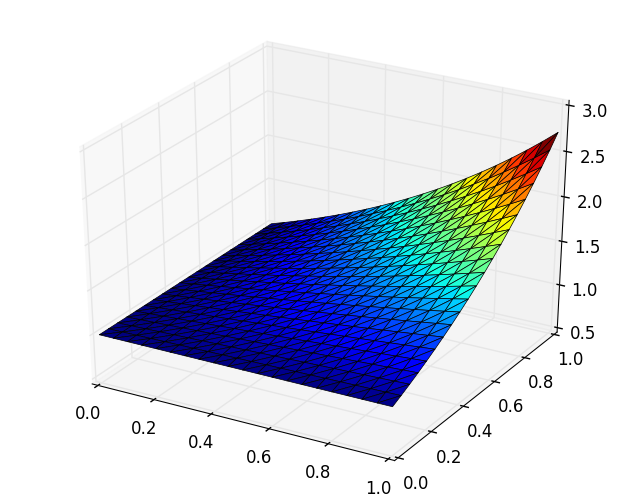

In [20]:
# Test Run
#-----------
# Assemble the system
#   (not the keyword parameters need not have the same names
#     as the keyworkds)
X, T, Ifree = square(20)
A, F = ellipticPDE(X, T, Afun=Afun, bfun=bfun, cfun=cfun, fbfun=fbfun, fsfun=fsfun)

# solve system, plot solution (looks about right)
#   (use list comprehension syntax to generate boundary condition)
Uexact = Float64[uDfun(X[:,j])  for j = 1:size(X,2)]
U = copy(Uexact)
U[Ifree] += full(A[Ifree, Ifree]) \ ((F - A * Uexact)[Ifree])
trisurf(T, X, U); 


In [21]:
# Error Analysis
NN = int32(floor(sqrt(2).^(6:10)))
errH1 = zeros(length(NN))
errL2 = zeros(length(NN))
# loop through mesh sizes
for n = 1:length(NN)
    # solve the problem: here, W = U - Uexact, 
    # so its norm will be the error
    X, T, Ifree = square(int32(NN[n]))
    # to avoid superconvergence, we have to perturb the mesh
    Iinterior = find( (X[1,:] .< 1) & (X[1,:] .> 0) & (X[2,:] .< 1) & (X[2,:] .> 0) )
    X[:, Iinterior] += 0.1 * (rand(size(X,1), length(Iinterior)) - 0.5) / NN[n]
    # change Ifree, to make life simpler
    A, F = ellipticPDE(X, T, Afun=Afun, bfun=bfun, cfun=cfun, fbfun=fbfun, fsfun=fsfun)
    U = Float64[u(X[:,j])  for j = 1:size(X,2)]
    W = zeros(size(X,2))
    G = (F - A * U)[Ifree]
    W[Ifree] = full(A[Ifree, Ifree]) \ G

    # H1 error
    AH1, = simple_stiffmat2(X, T)    
    errH1[n] = sqrt(dot(W, AH1*W))
    # L2 error: this is cheating a little, but what we are computing
    #      is really norm-equivalent to the L2 norm of W
    errL2[n] = norm(W, Inf) # norm(W, 2) / NN[n]
end

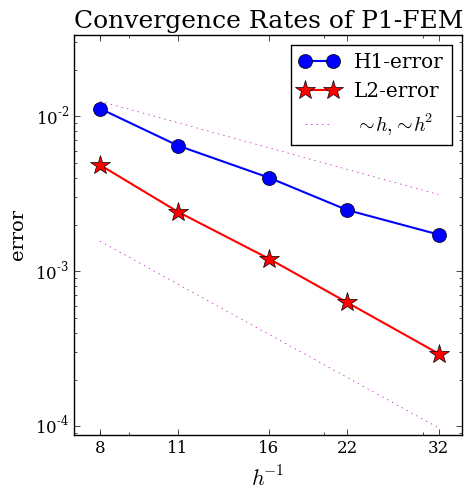

In [23]:
# We plot the result in a separate cell, so that we don't have to 
# rerun the simulation everytime we want to modify the plot
plt.rc("font", family="serif")
figure(figsize=[5,5])
loglog(NN, errH1, "b-o", linewidth=1.5, markersize=10)
loglog(NN, errL2, "r-*", linewidth=1.5, markersize=15)
loglog(NN, 0.1./NN.^(2), "m:", linewidth=0.5)
loglog(NN, 0.1./NN.^(1), "m:", linewidth=0.5)
legend(("H1-error", "L2-error", L"$\sim h, \sim h^2$"))
xlim([NN[1]*0.9, NN[end]*1.1])
ylim([0.3*minimum(errL2), 3*maximum(errH1)])
title("Convergence Rates of P1-FEM", fontsize=18)
xlabel(L"h^{-1}", fontsize=16)
ylabel("error", fontsize=14)
xticks(NN, NN);
# savefig("rate.png");